In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pandas as pd
import json
import os
import random

In [3]:
from nanocontrol import nanocontrol, controller
controller = controller()
nc = controller.ncs['1']

In [4]:
def chill(pos, seconds):
    nc.setFinePosVoltage('A', 0)
    nc.setFinePosVoltage('B', 0)
    nc.setFinePos16Bit('C', pos)
    nc.setFinePosVoltage('D', 0)
    time.sleep(seconds)
def reset(pos, seconds):
    nc.setFinePos16Bit('A', 0)
    nc.setFinePos16Bit('B', 0)
    nc.setFinePos16Bit('C', pos)
    nc.setFinePos16Bit('D', 0)
    time.sleep(seconds)
    nc.resetCoarseCounter()
    nc.resetCounter()

#### record noise at different positions

In [8]:
positions = [-np.power(2, 15),
             -np.power(2, 15) + np.power(2, 14),
             0,
             np.power(2, 15) - np.power(2, 14),
             np.power(2, 15)-1]
seconds = 60
for pos in positions:
    reset(pos, 60)
    counter = []
    start = time.time()
    while time.time() - start < seconds:
        counter.append(nc.readCounter()['C'])
    counter = np.array(counter).astype(int)
    np.save(f'../dat/noise/{pos}_{seconds}sec.npy', counter)

Finepos: -16384, mu: -1.0282290279627164, std: 1.0612416067100385
Finepos: -32768, mu: -2.9693741677762984, std: 1.6295766672133098
Finepos: 0, mu: 0.5922769640479361, std: 1.0977250451830858
Finepos: 16384, mu: 1.0047936085219706, std: 1.5686605950923973
Finepos: 32767, mu: -0.23275632490013315, std: 1.5670178256979728


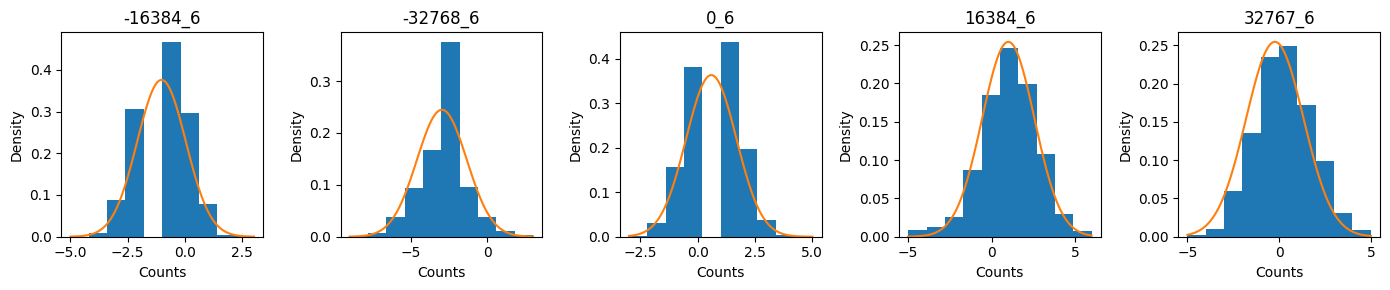

In [14]:
from scipy.stats import norm
fig, ax = plt.subplots(1, 5, figsize=(14, 3))
i = 0
all = []
for file in os.listdir('../dat/noise/'):
    if file.endswith('.npy'):
        counter = np.load(f'../dat/noise/{file}')
        mu, std = norm.fit(counter)
        print(f'Finepos: {file[:-10]}, mu: {mu}, std: {std}')
        ax[i].hist(counter, density=True)
        ax[i].set_title(f'{file[:-8]}')
        ax[i].set_xlabel('Counts')
        ax[i].set_ylabel('Density')
        x = np.linspace(min(counter), max(counter), 100)
        p = norm.pdf(x, mu, std)
        ax[i].plot(x, p)
        #ax[1, i].set_title(f'{file}')
        #ax[1, i].set_xlabel('Counts')
        #ax[1, i].set_ylabel('Density')
        # normalize to mean 0
        all.append(counter - mu)
        i += 1
plt.tight_layout()


Mean: 0.0, Std: 1.4073375618956234


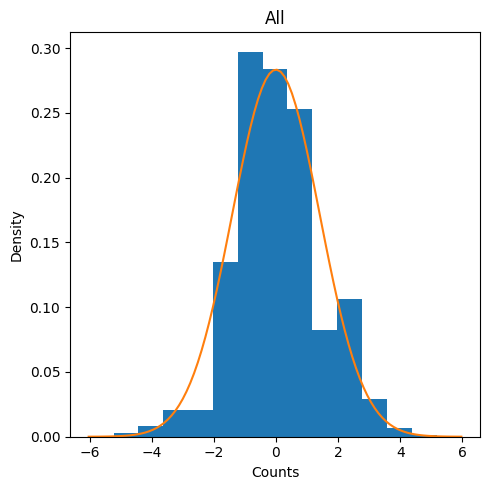

0.28347305664468625


In [8]:
mu, std = norm.fit(np.concatenate(all))
print(f'Mean: {mu}, Std: {std}')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.concatenate(all), bins=15, density=True)
ax.set_title(f'All')
ax.set_xlabel('Counts')
ax.set_ylabel('Density')
x = np.linspace(min(np.concatenate(all)), max(np.concatenate(all)), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p)
plt.tight_layout()
plt.show()
print(norm.pdf(0, mu, std))